[View in Colaboratory](https://colab.research.google.com/github/yylonly/GoogleCoLab/blob/master/4_ServeNet_2_BI_LTSM(512)_(Glove200b_trainedEmbeddingLayer).ipynb)

## ServeNet-LTSM (Glove50b-trainedEmbeddingLayer)

In [0]:
!pkill -9 -f ipykernel_launcher

In [1]:
!/opt/bin/nvidia-smi
printm()

Tue May  8 07:52:02 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.111                Driver Version: 384.111                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    25W / 149W |      1MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

NameError: ignored

In [0]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " I Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))


Gen RAM Free: 12.6 GB  I Proc size: 140.9 MB
GPU RAM Free: 11438MB | Used: 1MB | Util   0% | Total 11439MB


In [0]:
!kill -9 -1

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive


Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
import os
os.chdir("/content/drive/Colab Notebooks/")

In [4]:
!ls -l

total 14736
drwxr-xr-x 2 root root    4096 Mar  1 05:18 10.TensorFlow
drwxr-xr-x 2 root root    4096 Mar  1 07:27 14.Residual Networks
drwxr-xr-x 2 root root    4096 Mar  1 16:08 15.CarDetectionwithYOLOv2
drwxr-xr-x 2 root root    4096 Mar  1 16:27 16.Neural Style Transfer
drwxr-xr-x 2 root root    4096 Mar  1 18:00 17.Face Recognition
-rw-r--r-- 1 root root    1191 May  6 10:15 1D-CNN-BI-LTSM-glove50-loss.pdf
-rw-r--r-- 1 root root    1191 May  6 10:15 1DCNN-BI-LTSM-glove50-top5.pdf
drwxr-xr-x 2 root root    4096 Sep 15  2017 1.Python Basics with Numpy
drwxr-xr-x 2 root root    4096 Mar  1 06:26 2.Logistic Regression as a Neural Network
-rw-r--r-- 1 root root  702911 May  7 22:21 4.ServeNet-1-BI-LTSM(1024) (Glove200b-trainedEmbeddingLayer).ipynb
-rw-r--r-- 1 root root  764050 May  7 19:01 4.ServeNet-1-BI-LTSM(128) (Glove200b-trainedEmbeddingLayer).ipynb
-rw-r--r-- 1 root root  741240 May  8 06:23 4.ServeNet-1-BI-LTSM(512) (Glove200b-trainedEmbeddingLayer).ipynb
-rw-r--r-- 1 root root 

In [5]:
#import plaidml.keras
#plaidml.keras.install_backend()

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import h5py
import pandas as pd

#from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.models import load_model
from keras import metrics
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.initializers import glorot_uniform
from keras.callbacks import ModelCheckpoint
from keras.layers.wrappers import Bidirectional

np.random.seed(0)
%matplotlib inline

Using TensorFlow backend.


In [6]:
h5f = h5py.File('data/SplittedPaddedIndexedServiceDataset.h5','r') 
X_train = h5f['indexed_padded_Train_X'][:]
Y_train = h5f['Train_Y_one_hot'][:]
X_test = h5f['indexed_padded_Test_X'][:]
Y_test = h5f['Test_Y_one_hot'][:]
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
h5f.close()

(8123, 110) (8123, 50)
(2061, 110) (2061, 50)


In [7]:
X_train[0]

array([192973,  54273, 270501, 294803, 286278, 121851, 360915, 363921,
       270193, 219115, 154323, 278439, 291761, 191811, 191143, 270193,
       133719, 142813, 388756, 306178, 104329, 142808, 374253, 357266,
       286278, 354433,  54718, 345909, 236860, 142838,  90548, 327482,
       357354, 209662, 374253,  43010, 111455,  91182, 156214,  58791,
       270501,  57488,  54718, 149979, 136170, 270927, 294049,  43010,
       332120, 186717,  69725,  57459, 151349,  86371, 191143, 219115,
        57840, 386474,  58997,  89857, 156216, 122453, 374163, 182908,
       199199, 113067, 360915, 111448, 156216, 386474,  58997, 357412,
       182158, 269798, 357266, 286278,  54718, 107110,  88126, 354433,
       151349, 219113, 360915, 191135, 388711, 357266, 325899, 268046,
       325776, 188836, 281890,  61645, 373469, 363840,  54718,  61640,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0], dtype=int32)

In [8]:
Y_train[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [0]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [0]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('data/glove.6B.200d.txt')

In [0]:
# GRADED FUNCTION: pretrained_embedding_layer

def trainable_embedding_layer():
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    ### START CODE HERE ###
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        embedding_vector = word_to_vec_map.get(word)
        if embedding_vector is not None:
            emb_matrix[index, :] = embedding_vector

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)
    ### END CODE HERE ###

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [0]:
# GRADED FUNCTION: Emojify_V2

def ServeNet(input_shape):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    ### START CODE HERE ###
    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices = Input(shape=input_shape, dtype='int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = trainable_embedding_layer()
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices) 
     
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
    X = Bidirectional(LSTM(512, return_sequences=True))(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    
    X = Bidirectional(LSTM(512, return_sequences=False))(X)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X) 

    # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
    X = Dense(50)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices, outputs=X)
    
    ### END CODE HERE ###
    
    return model

In [0]:
maxLen = 110

In [14]:
model = ServeNet((maxLen, ))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 110)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 110, 200)          80000200  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 110, 1024)         2920448   
_________________________________________________________________
dropout_1 (Dropout)          (None, 110, 1024)         0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1024)              6295552   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                51250     
__________

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[metrics.categorical_accuracy, metrics.top_k_categorical_accuracy])

In [16]:
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 100, batch_size = 128)

Train on 8123 samples, validate on 2061 samples
Epoch 1/100
8123/8123 [==============================] - 93s 11ms/step - loss: 3.0679 - categorical_accuracy: 0.2183 - top_k_categorical_accuracy: 0.5014 - val_loss: 2.4266 - val_categorical_accuracy: 0.3430 - val_top_k_categorical_accuracy: 0.6807
Epoch 2/100
8123/8123 [==============================] - 92s 11ms/step - loss: 2.2783 - categorical_accuracy: 0.3962 - top_k_categorical_accuracy: 0.7188 - val_loss: 2.0476 - val_categorical_accuracy: 0.4677 - val_top_k_categorical_accuracy: 0.7593
Epoch 3/100
8123/8123 [==============================] - 91s 11ms/step - loss: 1.8929 - categorical_accuracy: 0.4823 - top_k_categorical_accuracy: 0.8007 - val_loss: 1.8234 - val_categorical_accuracy: 0.5046 - val_top_k_categorical_accuracy: 0.8161
Epoch 4/100
1664/8123 [=====>........................] - ETA: 1:06 - loss: 1.6276 - categorical_accuracy: 0.5523 - top_k_categorical_accuracy: 0.8552

8123/8123 [==============================] - 91s 11ms/step - loss: 1.6586 - categorical_accuracy: 0.5427 - top_k_categorical_accuracy: 0.8425 - val_loss: 1.7701 - val_categorical_accuracy: 0.5221 - val_top_k_categorical_accuracy: 0.8205
Epoch 5/100
8123/8123 [==============================] - 91s 11ms/step - loss: 1.4699 - categorical_accuracy: 0.5981 - top_k_categorical_accuracy: 0.8709 - val_loss: 1.6366 - val_categorical_accuracy: 0.5594 - val_top_k_categorical_accuracy: 0.8336
Epoch 6/100
8123/8123 [==============================] - 92s 11ms/step - loss: 1.3032 - categorical_accuracy: 0.6395 - top_k_categorical_accuracy: 0.8962 - val_loss: 1.5687 - val_categorical_accuracy: 0.5827 - val_top_k_categorical_accuracy: 0.8481
Epoch 7/100
3712/8123 [============>.................] - ETA: 45s - loss: 1.1562 - categorical_accuracy: 0.6676 - top_k_categorical_accuracy: 0.9197

8123/8123 [==============================] - 92s 11ms/step - loss: 1.1647 - categorical_accuracy: 0.6709 - top_k_categorical_accuracy: 0.9167 - val_loss: 1.5591 - val_categorical_accuracy: 0.5900 - val_top_k_categorical_accuracy: 0.8598
Epoch 8/100
8123/8123 [==============================] - 92s 11ms/step - loss: 1.0552 - categorical_accuracy: 0.7021 - top_k_categorical_accuracy: 0.9314 - val_loss: 1.5392 - val_categorical_accuracy: 0.6002 - val_top_k_categorical_accuracy: 0.8588
Epoch 9/100
8123/8123 [==============================] - 91s 11ms/step - loss: 0.9576 - categorical_accuracy: 0.7208 - top_k_categorical_accuracy: 0.9441 - val_loss: 1.5211 - val_categorical_accuracy: 0.6099 - val_top_k_categorical_accuracy: 0.8593
Epoch 10/100
3968/8123 [=============>................] - ETA: 42s - loss: 0.8198 - categorical_accuracy: 0.7626 - top_k_categorical_accuracy: 0.9594

8123/8123 [==============================] - 92s 11ms/step - loss: 0.8386 - categorical_accuracy: 0.7549 - top_k_categorical_accuracy: 0.9580 - val_loss: 1.5396 - val_categorical_accuracy: 0.6060 - val_top_k_categorical_accuracy: 0.8656
Epoch 11/100
8123/8123 [==============================] - 92s 11ms/step - loss: 0.7337 - categorical_accuracy: 0.7836 - top_k_categorical_accuracy: 0.9664 - val_loss: 1.5271 - val_categorical_accuracy: 0.6143 - val_top_k_categorical_accuracy: 0.8632
Epoch 12/100
8123/8123 [==============================] - 91s 11ms/step - loss: 0.5913 - categorical_accuracy: 0.8216 - top_k_categorical_accuracy: 0.9780 - val_loss: 1.6021 - val_categorical_accuracy: 0.6172 - val_top_k_categorical_accuracy: 0.8661
Epoch 13/100
3968/8123 [=============>................] - ETA: 42s - loss: 0.4776 - categorical_accuracy: 0.8591 - top_k_categorical_accuracy: 0.9836

8123/8123 [==============================] - 91s 11ms/step - loss: 0.5052 - categorical_accuracy: 0.8473 - top_k_categorical_accuracy: 0.9819 - val_loss: 1.5714 - val_categorical_accuracy: 0.6094 - val_top_k_categorical_accuracy: 0.8729
Epoch 14/100
8123/8123 [==============================] - 91s 11ms/step - loss: 0.4371 - categorical_accuracy: 0.8684 - top_k_categorical_accuracy: 0.9868 - val_loss: 1.6182 - val_categorical_accuracy: 0.6312 - val_top_k_categorical_accuracy: 0.8709
Epoch 15/100
8123/8123 [==============================] - 91s 11ms/step - loss: 0.3495 - categorical_accuracy: 0.8941 - top_k_categorical_accuracy: 0.9925 - val_loss: 1.7059 - val_categorical_accuracy: 0.6269 - val_top_k_categorical_accuracy: 0.8612
Epoch 16/100
3968/8123 [=============>................] - ETA: 42s - loss: 0.2785 - categorical_accuracy: 0.9166 - top_k_categorical_accuracy: 0.9957

8123/8123 [==============================] - 92s 11ms/step - loss: 0.2892 - categorical_accuracy: 0.9130 - top_k_categorical_accuracy: 0.9959 - val_loss: 1.8177 - val_categorical_accuracy: 0.6211 - val_top_k_categorical_accuracy: 0.8612
Epoch 17/100
8123/8123 [==============================] - 92s 11ms/step - loss: 0.2503 - categorical_accuracy: 0.9255 - top_k_categorical_accuracy: 0.9966 - val_loss: 1.9126 - val_categorical_accuracy: 0.6245 - val_top_k_categorical_accuracy: 0.8656
Epoch 18/100
8123/8123 [==============================] - 92s 11ms/step - loss: 0.2221 - categorical_accuracy: 0.9335 - top_k_categorical_accuracy: 0.9967 - val_loss: 1.8782 - val_categorical_accuracy: 0.6220 - val_top_k_categorical_accuracy: 0.8734
Epoch 19/100
3968/8123 [=============>................] - ETA: 42s - loss: 0.1454 - categorical_accuracy: 0.9549 - top_k_categorical_accuracy: 0.9992

8123/8123 [==============================] - 92s 11ms/step - loss: 0.1550 - categorical_accuracy: 0.9512 - top_k_categorical_accuracy: 0.9993 - val_loss: 1.8822 - val_categorical_accuracy: 0.6332 - val_top_k_categorical_accuracy: 0.8700
Epoch 20/100
8123/8123 [==============================] - 92s 11ms/step - loss: 0.1561 - categorical_accuracy: 0.9519 - top_k_categorical_accuracy: 0.9986 - val_loss: 1.8887 - val_categorical_accuracy: 0.6293 - val_top_k_categorical_accuracy: 0.8617
Epoch 21/100
8123/8123 [==============================] - 91s 11ms/step - loss: 0.1616 - categorical_accuracy: 0.9489 - top_k_categorical_accuracy: 0.9988 - val_loss: 1.9145 - val_categorical_accuracy: 0.6414 - val_top_k_categorical_accuracy: 0.8675
Epoch 22/100
3968/8123 [=============>................] - ETA: 42s - loss: 0.1543 - categorical_accuracy: 0.9506 - top_k_categorical_accuracy: 0.9995

8123/8123 [==============================] - 91s 11ms/step - loss: 0.1473 - categorical_accuracy: 0.9545 - top_k_categorical_accuracy: 0.9991 - val_loss: 2.0093 - val_categorical_accuracy: 0.6385 - val_top_k_categorical_accuracy: 0.8695
Epoch 23/100
8123/8123 [==============================] - 92s 11ms/step - loss: 0.1207 - categorical_accuracy: 0.9634 - top_k_categorical_accuracy: 0.9994 - val_loss: 2.0888 - val_categorical_accuracy: 0.6274 - val_top_k_categorical_accuracy: 0.8603
Epoch 24/100
8123/8123 [==============================] - 92s 11ms/step - loss: 0.0893 - categorical_accuracy: 0.9743 - top_k_categorical_accuracy: 0.9999 - val_loss: 2.1155 - val_categorical_accuracy: 0.6274 - val_top_k_categorical_accuracy: 0.8700
Epoch 25/100
3968/8123 [=============>................] - ETA: 42s - loss: 0.0908 - categorical_accuracy: 0.9733 - top_k_categorical_accuracy: 0.9995

8123/8123 [==============================] - 92s 11ms/step - loss: 0.0978 - categorical_accuracy: 0.9696 - top_k_categorical_accuracy: 0.9998 - val_loss: 2.0624 - val_categorical_accuracy: 0.6356 - val_top_k_categorical_accuracy: 0.8705
Epoch 26/100
8123/8123 [==============================] - 91s 11ms/step - loss: 0.0729 - categorical_accuracy: 0.9785 - top_k_categorical_accuracy: 0.9996 - val_loss: 2.1084 - val_categorical_accuracy: 0.6429 - val_top_k_categorical_accuracy: 0.8714
Epoch 27/100
8123/8123 [==============================] - 91s 11ms/step - loss: 0.0849 - categorical_accuracy: 0.9734 - top_k_categorical_accuracy: 0.9999 - val_loss: 2.1668 - val_categorical_accuracy: 0.6380 - val_top_k_categorical_accuracy: 0.8651
Epoch 28/100
3968/8123 [=============>................] - ETA: 42s - loss: 0.0625 - categorical_accuracy: 0.9836 - top_k_categorical_accuracy: 0.9992

8123/8123 [==============================] - 92s 11ms/step - loss: 0.0633 - categorical_accuracy: 0.9830 - top_k_categorical_accuracy: 0.9996 - val_loss: 2.1611 - val_categorical_accuracy: 0.6400 - val_top_k_categorical_accuracy: 0.8743
Epoch 29/100
8123/8123 [==============================] - 92s 11ms/step - loss: 0.0457 - categorical_accuracy: 0.9883 - top_k_categorical_accuracy: 0.9999 - val_loss: 2.1911 - val_categorical_accuracy: 0.6346 - val_top_k_categorical_accuracy: 0.8768
Epoch 30/100
8123/8123 [==============================] - 91s 11ms/step - loss: 0.0358 - categorical_accuracy: 0.9905 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.2339 - val_categorical_accuracy: 0.6424 - val_top_k_categorical_accuracy: 0.8646
Epoch 31/100
3968/8123 [=============>................] - ETA: 42s - loss: 0.0429 - categorical_accuracy: 0.9894 - top_k_categorical_accuracy: 1.0000

8123/8123 [==============================] - 91s 11ms/step - loss: 0.0386 - categorical_accuracy: 0.9908 - top_k_categorical_accuracy: 0.9999 - val_loss: 2.2200 - val_categorical_accuracy: 0.6380 - val_top_k_categorical_accuracy: 0.8685
Epoch 32/100
8123/8123 [==============================] - 92s 11ms/step - loss: 0.0257 - categorical_accuracy: 0.9932 - top_k_categorical_accuracy: 0.9999 - val_loss: 2.3318 - val_categorical_accuracy: 0.6312 - val_top_k_categorical_accuracy: 0.8690
Epoch 33/100
8123/8123 [==============================] - 92s 11ms/step - loss: 0.0322 - categorical_accuracy: 0.9922 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.3494 - val_categorical_accuracy: 0.6429 - val_top_k_categorical_accuracy: 0.8627
Epoch 34/100
3968/8123 [=============>................] - ETA: 42s - loss: 0.0318 - categorical_accuracy: 0.9924 - top_k_categorical_accuracy: 1.0000

8123/8123 [==============================] - 91s 11ms/step - loss: 0.0491 - categorical_accuracy: 0.9870 - top_k_categorical_accuracy: 0.9998 - val_loss: 2.3941 - val_categorical_accuracy: 0.6264 - val_top_k_categorical_accuracy: 0.8583
Epoch 35/100
8123/8123 [==============================] - 92s 11ms/step - loss: 0.0589 - categorical_accuracy: 0.9846 - top_k_categorical_accuracy: 0.9999 - val_loss: 2.3939 - val_categorical_accuracy: 0.6303 - val_top_k_categorical_accuracy: 0.8510
Epoch 36/100
8123/8123 [==============================] - 91s 11ms/step - loss: 0.0805 - categorical_accuracy: 0.9760 - top_k_categorical_accuracy: 0.9995 - val_loss: 2.3122 - val_categorical_accuracy: 0.6259 - val_top_k_categorical_accuracy: 0.8666
Epoch 37/100
3968/8123 [=============>................] - ETA: 42s - loss: 0.0721 - categorical_accuracy: 0.9796 - top_k_categorical_accuracy: 0.9992

8123/8123 [==============================] - 92s 11ms/step - loss: 0.0650 - categorical_accuracy: 0.9818 - top_k_categorical_accuracy: 0.9995 - val_loss: 2.2497 - val_categorical_accuracy: 0.6385 - val_top_k_categorical_accuracy: 0.8632
Epoch 38/100
8123/8123 [==============================] - 91s 11ms/step - loss: 0.0565 - categorical_accuracy: 0.9850 - top_k_categorical_accuracy: 0.9996 - val_loss: 2.3115 - val_categorical_accuracy: 0.6342 - val_top_k_categorical_accuracy: 0.8705
Epoch 39/100
8123/8123 [==============================] - 92s 11ms/step - loss: 0.0349 - categorical_accuracy: 0.9916 - top_k_categorical_accuracy: 0.9998 - val_loss: 2.4528 - val_categorical_accuracy: 0.6342 - val_top_k_categorical_accuracy: 0.8671
Epoch 40/100
3968/8123 [=============>................] - ETA: 42s - loss: 0.0266 - categorical_accuracy: 0.9914 - top_k_categorical_accuracy: 1.0000

8123/8123 [==============================] - 91s 11ms/step - loss: 0.0253 - categorical_accuracy: 0.9929 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.4581 - val_categorical_accuracy: 0.6410 - val_top_k_categorical_accuracy: 0.8549
Epoch 41/100
8123/8123 [==============================] - 92s 11ms/step - loss: 0.0194 - categorical_accuracy: 0.9951 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.4578 - val_categorical_accuracy: 0.6356 - val_top_k_categorical_accuracy: 0.8549
Epoch 42/100
8123/8123 [==============================] - 91s 11ms/step - loss: 0.0541 - categorical_accuracy: 0.9849 - top_k_categorical_accuracy: 0.9999 - val_loss: 2.4743 - val_categorical_accuracy: 0.6225 - val_top_k_categorical_accuracy: 0.8622
Epoch 43/100
3968/8123 [=============>................] - ETA: 42s - loss: 0.0756 - categorical_accuracy: 0.9776 - top_k_categorical_accuracy: 0.9995

8123/8123 [==============================] - 92s 11ms/step - loss: 0.1124 - categorical_accuracy: 0.9670 - top_k_categorical_accuracy: 0.9990 - val_loss: 2.3741 - val_categorical_accuracy: 0.6191 - val_top_k_categorical_accuracy: 0.8569
Epoch 44/100
8123/8123 [==============================] - 92s 11ms/step - loss: 0.0880 - categorical_accuracy: 0.9733 - top_k_categorical_accuracy: 0.9996 - val_loss: 2.2510 - val_categorical_accuracy: 0.6371 - val_top_k_categorical_accuracy: 0.8637
Epoch 45/100
8123/8123 [==============================] - 92s 11ms/step - loss: 0.0379 - categorical_accuracy: 0.9892 - top_k_categorical_accuracy: 0.9998 - val_loss: 2.3264 - val_categorical_accuracy: 0.6419 - val_top_k_categorical_accuracy: 0.8612
Epoch 46/100
3968/8123 [=============>................] - ETA: 42s - loss: 0.0343 - categorical_accuracy: 0.9912 - top_k_categorical_accuracy: 1.0000

8123/8123 [==============================] - 92s 11ms/step - loss: 0.0413 - categorical_accuracy: 0.9887 - top_k_categorical_accuracy: 0.9999 - val_loss: 2.4094 - val_categorical_accuracy: 0.6443 - val_top_k_categorical_accuracy: 0.8661
Epoch 47/100
8123/8123 [==============================] - 91s 11ms/step - loss: 0.0229 - categorical_accuracy: 0.9940 - top_k_categorical_accuracy: 0.9999 - val_loss: 2.5182 - val_categorical_accuracy: 0.6327 - val_top_k_categorical_accuracy: 0.8632
Epoch 48/100
8123/8123 [==============================] - 92s 11ms/step - loss: 0.0318 - categorical_accuracy: 0.9916 - top_k_categorical_accuracy: 0.9999 - val_loss: 2.4573 - val_categorical_accuracy: 0.6371 - val_top_k_categorical_accuracy: 0.8598
Epoch 49/100
3968/8123 [=============>................] - ETA: 42s - loss: 0.0224 - categorical_accuracy: 0.9940 - top_k_categorical_accuracy: 0.9997

8123/8123 [==============================] - 91s 11ms/step - loss: 0.0283 - categorical_accuracy: 0.9925 - top_k_categorical_accuracy: 0.9999 - val_loss: 2.5247 - val_categorical_accuracy: 0.6317 - val_top_k_categorical_accuracy: 0.8646
Epoch 50/100
8123/8123 [==============================] - 91s 11ms/step - loss: 0.0358 - categorical_accuracy: 0.9918 - top_k_categorical_accuracy: 0.9999 - val_loss: 2.3959 - val_categorical_accuracy: 0.6443 - val_top_k_categorical_accuracy: 0.8685
Epoch 51/100
8123/8123 [==============================] - 92s 11ms/step - loss: 0.0322 - categorical_accuracy: 0.9918 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.4603 - val_categorical_accuracy: 0.6356 - val_top_k_categorical_accuracy: 0.8583
Epoch 52/100
3968/8123 [=============>................] - ETA: 42s - loss: 0.0229 - categorical_accuracy: 0.9942 - top_k_categorical_accuracy: 0.9997

8123/8123 [==============================] - 92s 11ms/step - loss: 0.0267 - categorical_accuracy: 0.9929 - top_k_categorical_accuracy: 0.9998 - val_loss: 2.5230 - val_categorical_accuracy: 0.6279 - val_top_k_categorical_accuracy: 0.8593
Epoch 53/100
8123/8123 [==============================] - 92s 11ms/step - loss: 0.0202 - categorical_accuracy: 0.9947 - top_k_categorical_accuracy: 0.9999 - val_loss: 2.5201 - val_categorical_accuracy: 0.6376 - val_top_k_categorical_accuracy: 0.8661
Epoch 54/100
8123/8123 [==============================] - 91s 11ms/step - loss: 0.0089 - categorical_accuracy: 0.9982 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.5417 - val_categorical_accuracy: 0.6400 - val_top_k_categorical_accuracy: 0.8637
Epoch 55/100
3968/8123 [=============>................] - ETA: 42s - loss: 0.0040 - categorical_accuracy: 0.9995 - top_k_categorical_accuracy: 1.0000

8123/8123 [==============================] - 91s 11ms/step - loss: 0.0046 - categorical_accuracy: 0.9991 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.5497 - val_categorical_accuracy: 0.6487 - val_top_k_categorical_accuracy: 0.8729
Epoch 56/100
8123/8123 [==============================] - 91s 11ms/step - loss: 0.0031 - categorical_accuracy: 0.9999 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.5854 - val_categorical_accuracy: 0.6395 - val_top_k_categorical_accuracy: 0.8656
Epoch 57/100
8123/8123 [==============================] - 91s 11ms/step - loss: 0.0037 - categorical_accuracy: 0.9993 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.5527 - val_categorical_accuracy: 0.6390 - val_top_k_categorical_accuracy: 0.8588
Epoch 58/100
3968/8123 [=============>................] - ETA: 42s - loss: 0.0085 - categorical_accuracy: 0.9980 - top_k_categorical_accuracy: 1.0000

8123/8123 [==============================] - 92s 11ms/step - loss: 0.0075 - categorical_accuracy: 0.9983 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.5704 - val_categorical_accuracy: 0.6477 - val_top_k_categorical_accuracy: 0.8632
Epoch 59/100
8123/8123 [==============================] - 91s 11ms/step - loss: 0.0030 - categorical_accuracy: 0.9995 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.5895 - val_categorical_accuracy: 0.6463 - val_top_k_categorical_accuracy: 0.8690
Epoch 60/100
8123/8123 [==============================] - 91s 11ms/step - loss: 0.0019 - categorical_accuracy: 0.9998 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.6235 - val_categorical_accuracy: 0.6463 - val_top_k_categorical_accuracy: 0.8675
Epoch 61/100
3968/8123 [=============>................] - ETA: 42s - loss: 0.0012 - categorical_accuracy: 0.9997 - top_k_categorical_accuracy: 1.0000

8123/8123 [==============================] - 91s 11ms/step - loss: 0.0025 - categorical_accuracy: 0.9995 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.6392 - val_categorical_accuracy: 0.6429 - val_top_k_categorical_accuracy: 0.8661
Epoch 62/100
8123/8123 [==============================] - 92s 11ms/step - loss: 0.0092 - categorical_accuracy: 0.9984 - top_k_categorical_accuracy: 0.9998 - val_loss: 2.7041 - val_categorical_accuracy: 0.6473 - val_top_k_categorical_accuracy: 0.8637
Epoch 63/100
8123/8123 [==============================] - 91s 11ms/step - loss: 0.0425 - categorical_accuracy: 0.9879 - top_k_categorical_accuracy: 0.9995 - val_loss: 2.6489 - val_categorical_accuracy: 0.6298 - val_top_k_categorical_accuracy: 0.8496
Epoch 64/100
3968/8123 [=============>................] - ETA: 42s - loss: 0.1104 - categorical_accuracy: 0.9675 - top_k_categorical_accuracy: 0.9995

8123/8123 [==============================] - 92s 11ms/step - loss: 0.1241 - categorical_accuracy: 0.9626 - top_k_categorical_accuracy: 0.9989 - val_loss: 2.3846 - val_categorical_accuracy: 0.6201 - val_top_k_categorical_accuracy: 0.8404
Epoch 65/100
8123/8123 [==============================] - 92s 11ms/step - loss: 0.1534 - categorical_accuracy: 0.9556 - top_k_categorical_accuracy: 0.9979 - val_loss: 2.4034 - val_categorical_accuracy: 0.6148 - val_top_k_categorical_accuracy: 0.8501
Epoch 66/100
8123/8123 [==============================] - 92s 11ms/step - loss: 0.1409 - categorical_accuracy: 0.9590 - top_k_categorical_accuracy: 0.9980 - val_loss: 2.4473 - val_categorical_accuracy: 0.6172 - val_top_k_categorical_accuracy: 0.8637
Epoch 67/100
3968/8123 [=============>................] - ETA: 42s - loss: 0.0499 - categorical_accuracy: 0.9854 - top_k_categorical_accuracy: 1.0000

8123/8123 [==============================] - 92s 11ms/step - loss: 0.0465 - categorical_accuracy: 0.9862 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.3886 - val_categorical_accuracy: 0.6376 - val_top_k_categorical_accuracy: 0.8607
Epoch 68/100
8123/8123 [==============================] - 92s 11ms/step - loss: 0.0399 - categorical_accuracy: 0.9877 - top_k_categorical_accuracy: 0.9999 - val_loss: 2.5476 - val_categorical_accuracy: 0.6346 - val_top_k_categorical_accuracy: 0.8617
Epoch 69/100
8123/8123 [==============================] - 91s 11ms/step - loss: 0.0236 - categorical_accuracy: 0.9943 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.5177 - val_categorical_accuracy: 0.6376 - val_top_k_categorical_accuracy: 0.8549
Epoch 70/100
3968/8123 [=============>................] - ETA: 42s - loss: 0.0099 - categorical_accuracy: 0.9977 - top_k_categorical_accuracy: 1.0000

8123/8123 [==============================] - 91s 11ms/step - loss: 0.0104 - categorical_accuracy: 0.9975 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.5716 - val_categorical_accuracy: 0.6453 - val_top_k_categorical_accuracy: 0.8627
Epoch 71/100
8123/8123 [==============================] - 92s 11ms/step - loss: 0.0163 - categorical_accuracy: 0.9962 - top_k_categorical_accuracy: 0.9998 - val_loss: 2.5701 - val_categorical_accuracy: 0.6487 - val_top_k_categorical_accuracy: 0.8675
Epoch 72/100
8123/8123 [==============================] - 92s 11ms/step - loss: 0.0169 - categorical_accuracy: 0.9957 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.5628 - val_categorical_accuracy: 0.6439 - val_top_k_categorical_accuracy: 0.8671
Epoch 73/100
3968/8123 [=============>................] - ETA: 42s - loss: 0.0197 - categorical_accuracy: 0.9950 - top_k_categorical_accuracy: 1.0000

8123/8123 [==============================] - 92s 11ms/step - loss: 0.0178 - categorical_accuracy: 0.9957 - top_k_categorical_accuracy: 0.9999 - val_loss: 2.5406 - val_categorical_accuracy: 0.6405 - val_top_k_categorical_accuracy: 0.8685
Epoch 74/100
8123/8123 [==============================] - 91s 11ms/step - loss: 0.0140 - categorical_accuracy: 0.9967 - top_k_categorical_accuracy: 0.9999 - val_loss: 2.6360 - val_categorical_accuracy: 0.6376 - val_top_k_categorical_accuracy: 0.8617
Epoch 75/100
8123/8123 [==============================] - 92s 11ms/step - loss: 0.0101 - categorical_accuracy: 0.9969 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.6658 - val_categorical_accuracy: 0.6395 - val_top_k_categorical_accuracy: 0.8641
Epoch 76/100
3968/8123 [=============>................] - ETA: 42s - loss: 0.0150 - categorical_accuracy: 0.9957 - top_k_categorical_accuracy: 1.0000

8123/8123 [==============================] - 91s 11ms/step - loss: 0.0142 - categorical_accuracy: 0.9957 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.6535 - val_categorical_accuracy: 0.6385 - val_top_k_categorical_accuracy: 0.8646
Epoch 77/100
8123/8123 [==============================] - 91s 11ms/step - loss: 0.0148 - categorical_accuracy: 0.9958 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.6929 - val_categorical_accuracy: 0.6288 - val_top_k_categorical_accuracy: 0.8598
Epoch 78/100
8123/8123 [==============================] - 91s 11ms/step - loss: 0.0290 - categorical_accuracy: 0.9915 - top_k_categorical_accuracy: 0.9998 - val_loss: 2.7030 - val_categorical_accuracy: 0.6351 - val_top_k_categorical_accuracy: 0.8501
Epoch 79/100
3968/8123 [=============>................] - ETA: 42s - loss: 0.0204 - categorical_accuracy: 0.9942 - top_k_categorical_accuracy: 1.0000

8123/8123 [==============================] - 91s 11ms/step - loss: 0.0188 - categorical_accuracy: 0.9950 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.7466 - val_categorical_accuracy: 0.6249 - val_top_k_categorical_accuracy: 0.8612
Epoch 80/100
8123/8123 [==============================] - 92s 11ms/step - loss: 0.0187 - categorical_accuracy: 0.9950 - top_k_categorical_accuracy: 0.9999 - val_loss: 2.6698 - val_categorical_accuracy: 0.6283 - val_top_k_categorical_accuracy: 0.8476
Epoch 81/100
8123/8123 [==============================] - 91s 11ms/step - loss: 0.0292 - categorical_accuracy: 0.9910 - top_k_categorical_accuracy: 0.9998 - val_loss: 2.7255 - val_categorical_accuracy: 0.6410 - val_top_k_categorical_accuracy: 0.8544
Epoch 82/100
3968/8123 [=============>................] - ETA: 42s - loss: 0.0174 - categorical_accuracy: 0.9947 - top_k_categorical_accuracy: 1.0000

4096/8123 [==============>...............] - ETA: 41s - loss: 0.0172 - categorical_accuracy: 0.9949 - top_k_categorical_accuracy: 1.0000

KeyboardInterrupt: ignored

In [0]:
!ls -l

total 13372
drwxr-xr-x 2 root root    4096 Mar  1 05:18 10.TensorFlow
drwxr-xr-x 2 root root    4096 Mar  1 07:27 14.Residual Networks
drwxr-xr-x 2 root root    4096 Mar  1 16:08 15.CarDetectionwithYOLOv2
drwxr-xr-x 2 root root    4096 Mar  1 16:27 16.Neural Style Transfer
drwxr-xr-x 2 root root    4096 Mar  1 18:00 17.Face Recognition
-rw-r--r-- 1 root root    1191 May  6 10:15 1D-CNN-BI-LTSM-glove50-loss.pdf
-rw-r--r-- 1 root root    1191 May  6 10:15 1DCNN-BI-LTSM-glove50-top5.pdf
drwxr-xr-x 2 root root    4096 Sep 15  2017 1.Python Basics with Numpy
drwxr-xr-x 2 root root    4096 Mar  1 06:26 2.Logistic Regression as a Neural Network
-rw-r--r-- 1 root root  764050 May  7 19:01 4.ServeNet-1-BI-LTSM(128) (Glove200b-trainedEmbeddingLayer).ipynb
-rw-r--r-- 1 root root  766118 May  7 20:09 4.ServeNet-1-BI-LTSM(512) (Glove200b-trainedEmbeddingLayer).ipynb
-rw-r--r-- 1 root root  761164 May  7 17:59 4.ServeNet-1-BI-LTSM (Glove200b-trainedEmbeddingLayer).ipynb
-rw-r--r-- 1 root root  73984

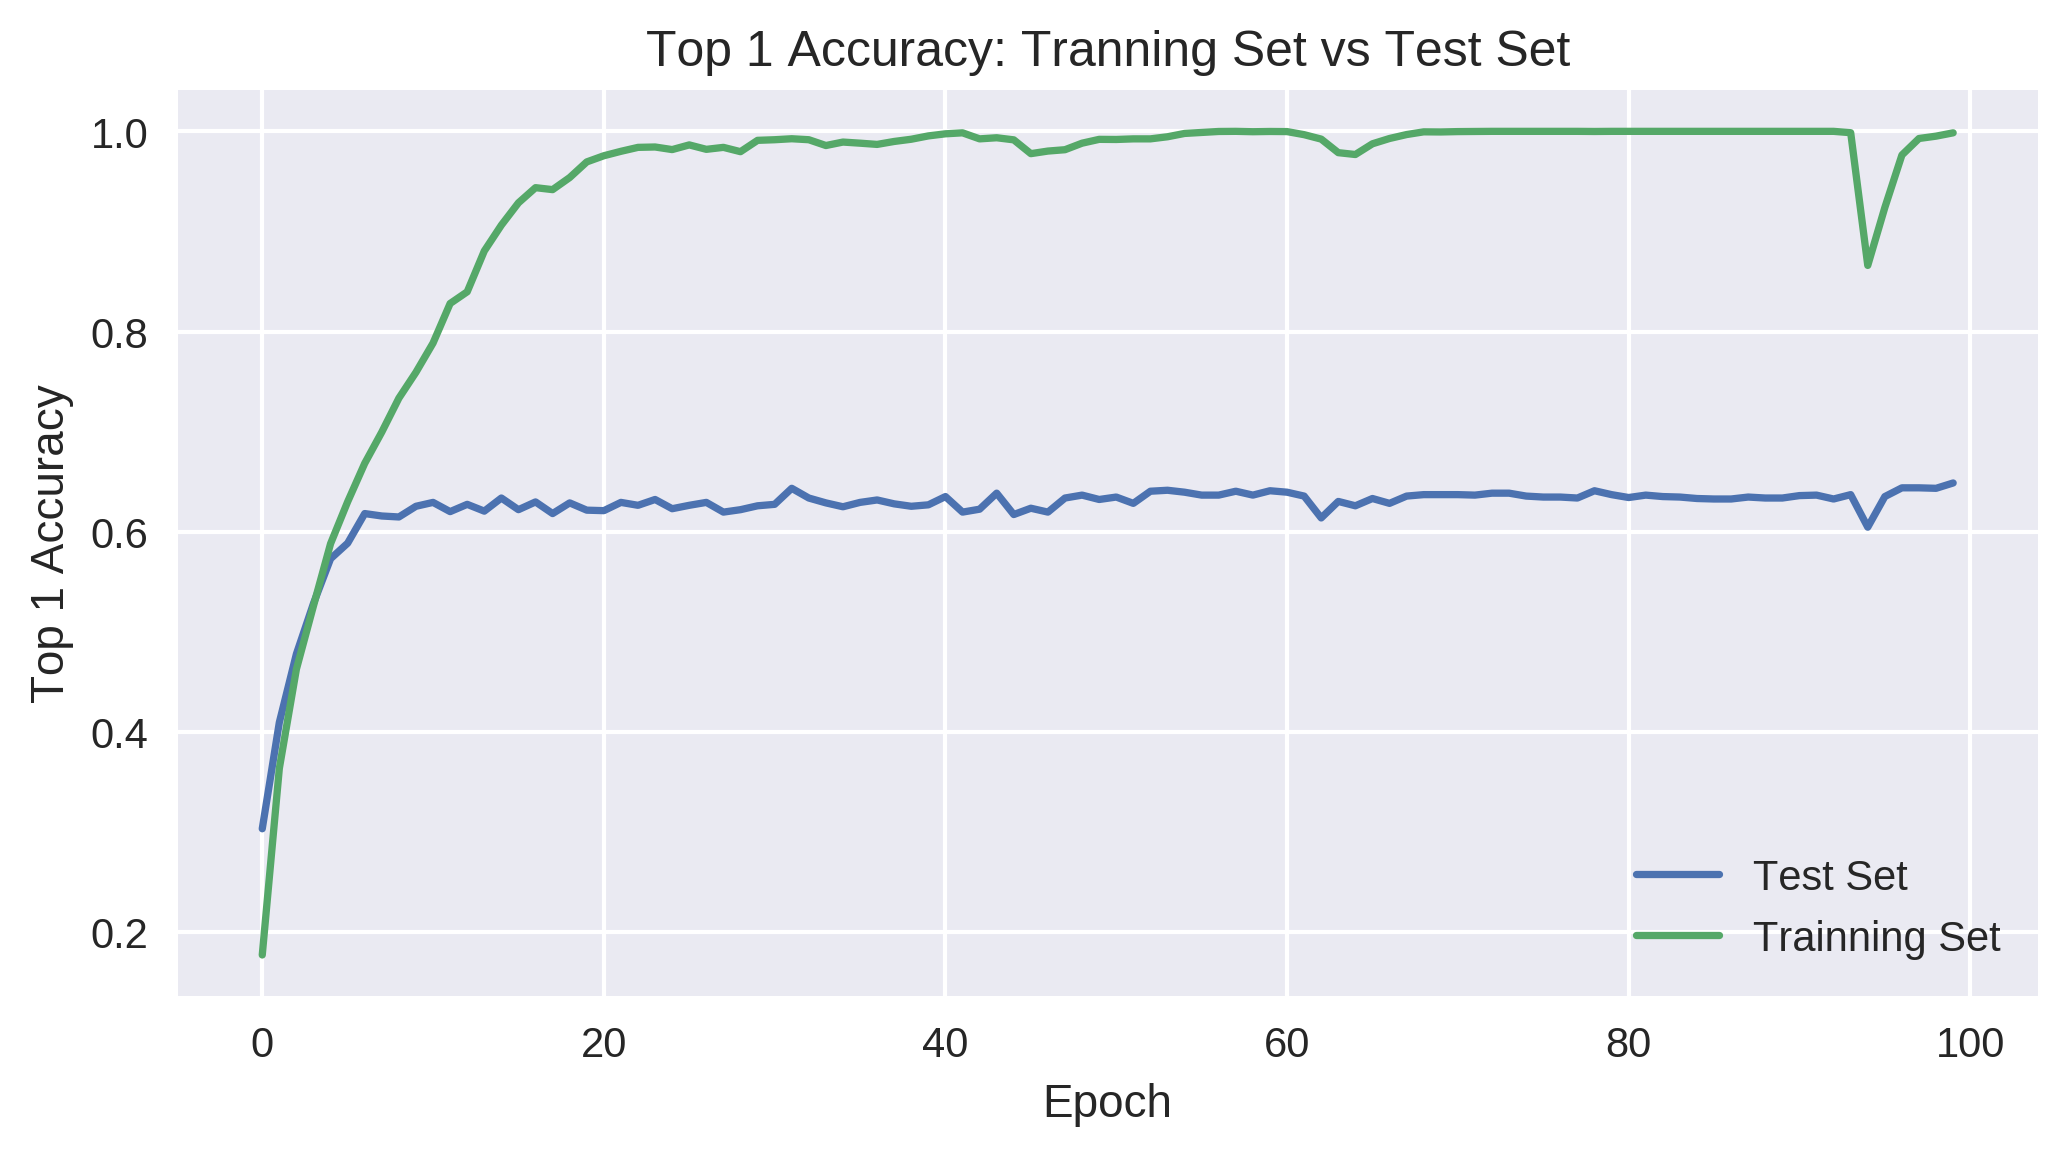

In [0]:
# plot metrics
plt.figure(figsize=(8, 4), dpi=300)
plt.title("Top 1 Accuracy: Tranning Set vs Test Set")
plt.xlabel("Epoch")
plt.ylabel("Top 1 Accuracy")
plt.plot(history.history['val_categorical_accuracy'], label="Test Set")
plt.plot(history.history['categorical_accuracy'], label="Trainning Set")
plt.legend()
plt.show()

### Plot Loss

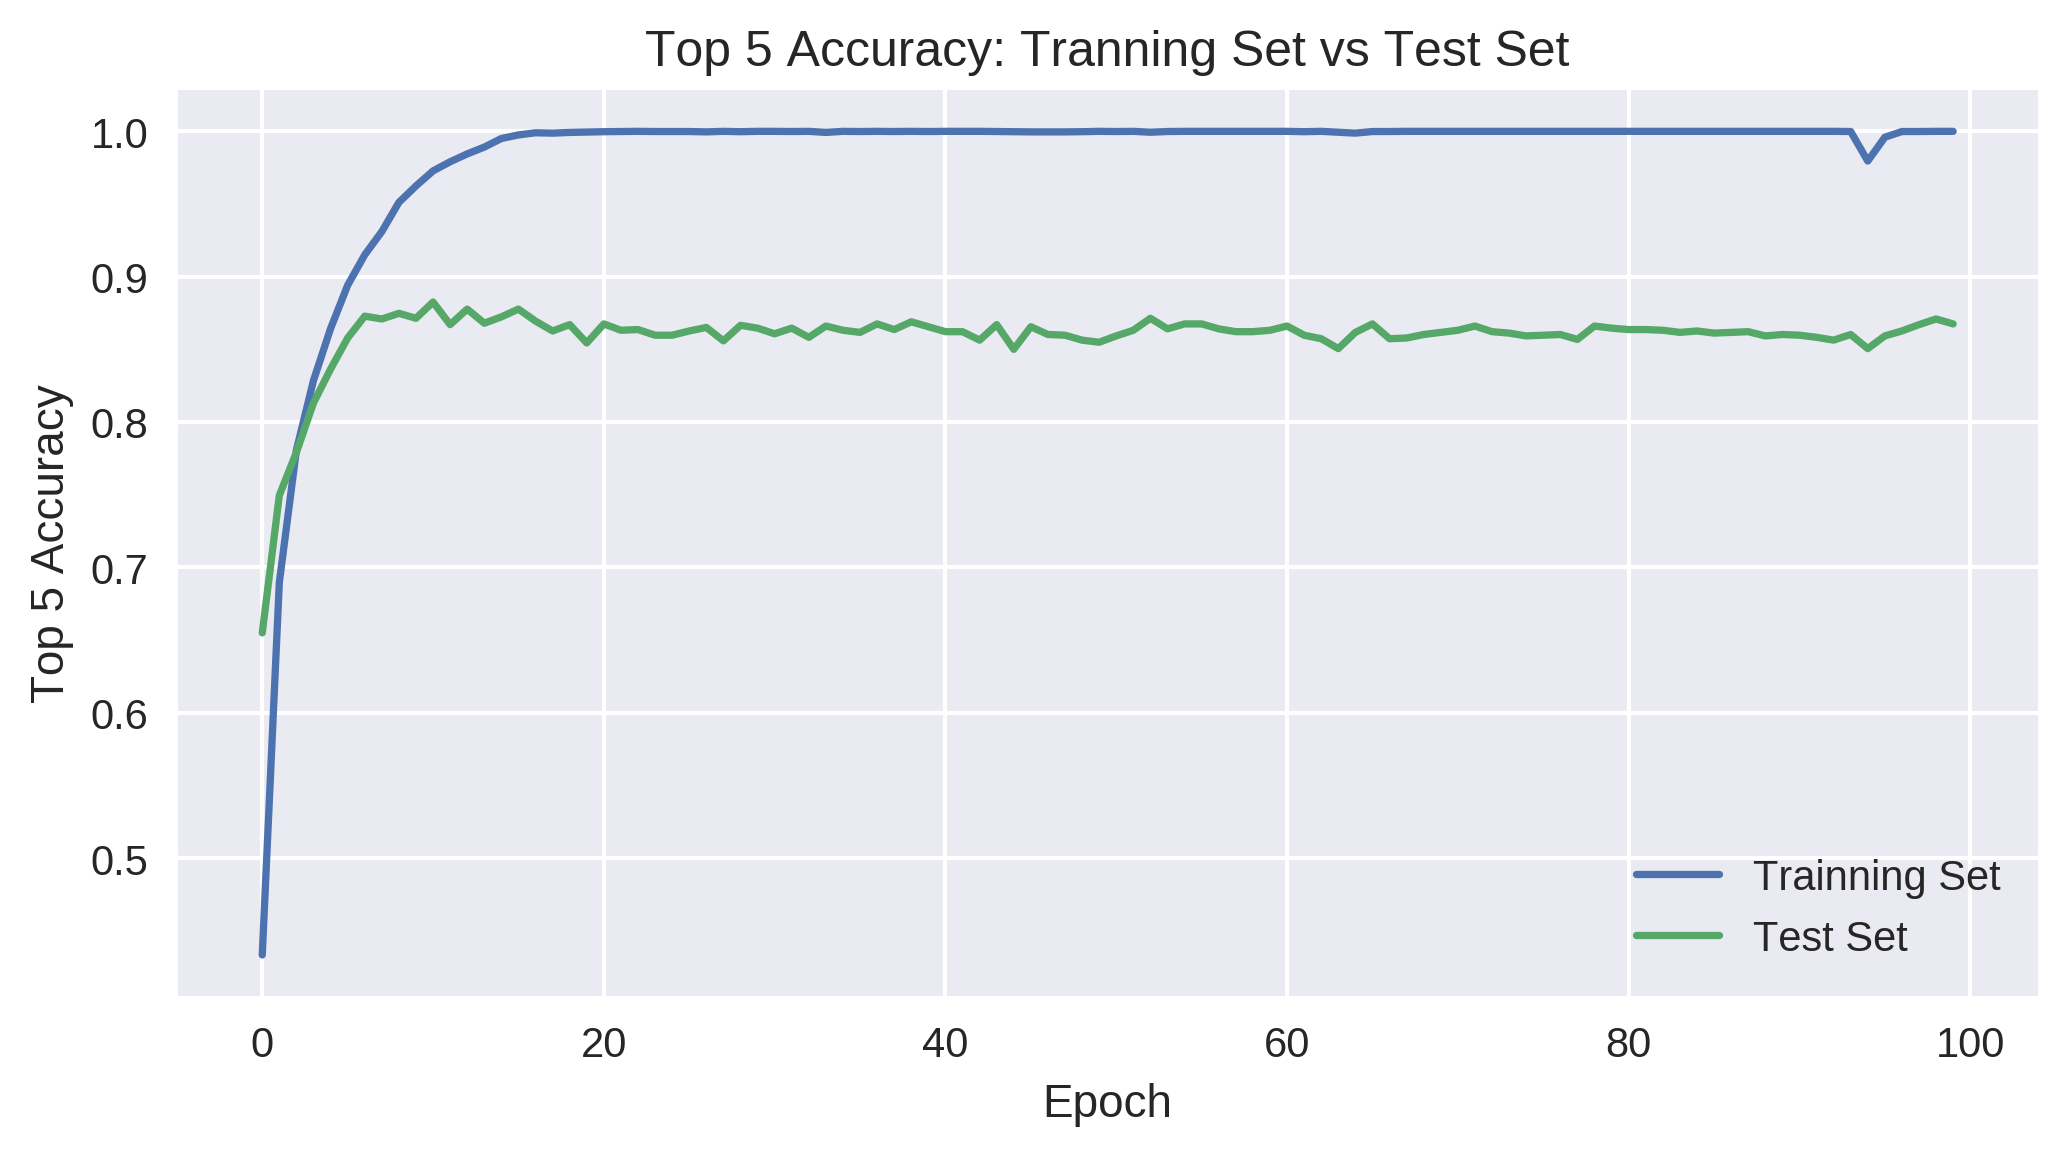

In [0]:
# plot metrics
plt.figure(figsize=(8, 4), dpi=300)
plt.title("Top 5 Accuracy: Tranning Set vs Test Set")
plt.xlabel("Epoch")
plt.ylabel("Top 5 Accuracy")
plt.plot(history.history['top_k_categorical_accuracy'], label="Trainning Set")
plt.plot(history.history['val_top_k_categorical_accuracy'], label="Test Set")
plt.legend()
plt.show()

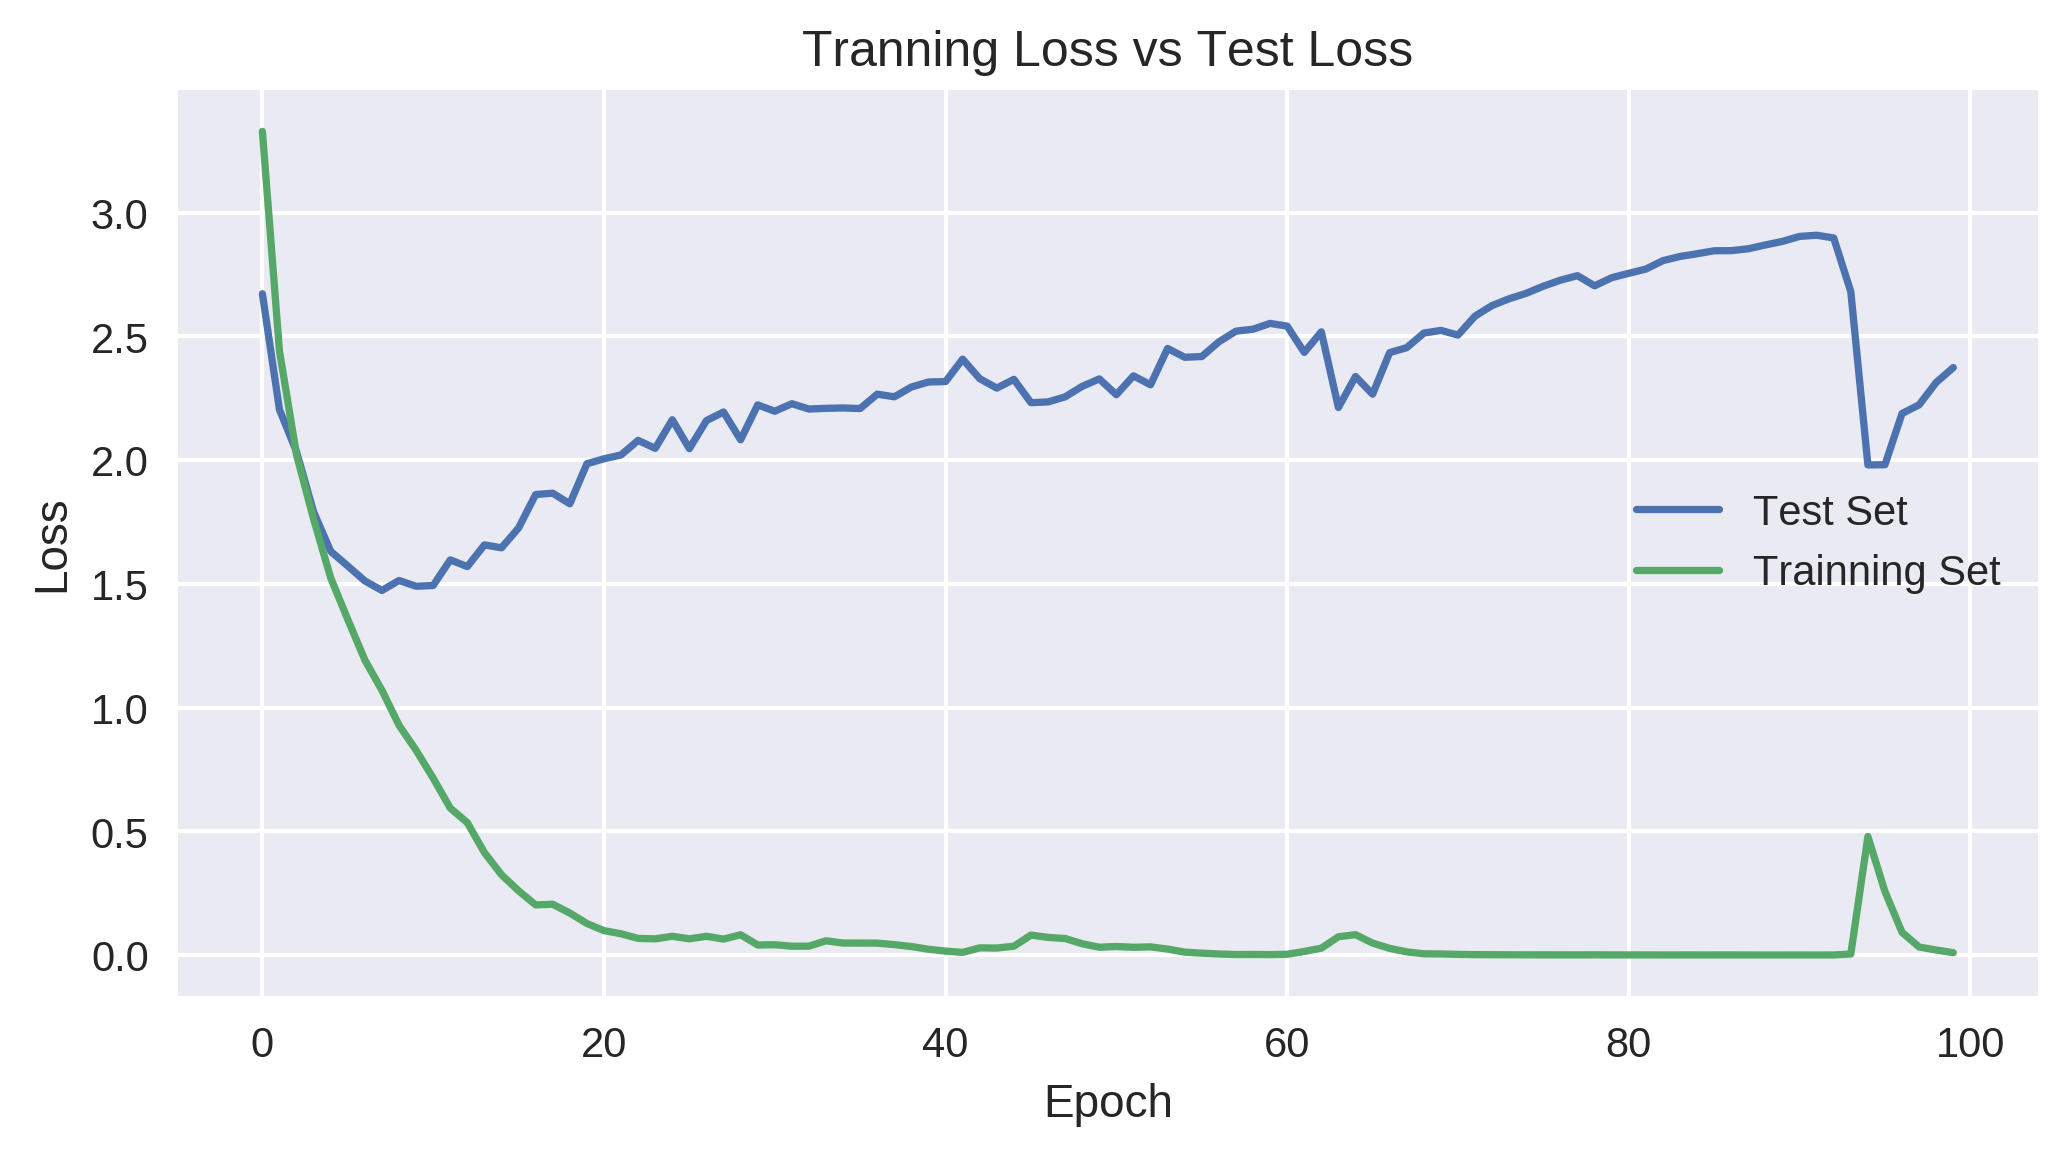

In [0]:
# plot metrics
plt.figure(figsize=(8, 4), dpi=300)
plt.title("Tranning Loss vs Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['val_loss'], label="Test Set")
plt.plot(history.history['loss'], label="Trainning Set")
plt.legend()
plt.show()


### Save History

In [0]:
import pickle
  
f = open('ServeNet/trainHistoryDictGlove200-2-BI-LTSM(512)', 'wb')
pickle.dump(history.history, f)
f.close()
  

### Load History

In [0]:
import pickle

f = open('ServeNet/trainHistoryDictGlove200-2-BI-LTSM(512)', 'rb')
his = pickle.load(f)
f.close()

In [0]:
val_top_k = his['val_top_k_categorical_accuracy']
print(max(val_top_k))
print(np.argmax(val_top_k))
val_loss = his['val_loss']
print(min(val_loss))
print(np.argmin(val_loss))
val_ca = his['val_categorical_accuracy']
print(max(val_ca))
print(np.argmax(val_ca))

0.8825812712854
10
1.4734096639310197
7
0.6487142165154869
99


### Model Save

In [0]:
model.save('ServeNet/Serve_Net_Glove200_2_BI_LTSM(512).h5') 

### Model Load

In [0]:
model = load_model('ServeNet/Serve_Net_Glove200_2_BI_LTSM(512).h5')

In [0]:
print("Training set:")
loss_train, mae_train, top5error_train = model.evaluate(X_train, Y_train)
print("Training accuracy = ", top5error_train)
print('Test set:')
loss_test, mae_test, top5error_test = model.evaluate(X_test, Y_test)
print("Training accuracy = ", top5error_test)

Training set:
8123/8123 [==============================] - 38s 5ms/step
Training accuracy =  1.0
Test set:
2061/2061 [==============================] - 10s 5ms/step
Training accuracy =  0.867540029169922


In [0]:
# This code allows you to see the mislabelled examples
C = 50
# y_test_oh = np.eye(C)[Y_test.reshape(-1)]
# X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
predY_test = model.predict(X_test)

In [0]:
print(predY_test.shape)
print(Y_test.shape)

(2061, 50)
(2061, 50)


In [0]:
print(np.argmax(predY_test[0]))
print(np.argmax(Y_test[0]))

46
21


In [0]:
# Heatmap Data
non_onehot_pred_test = np.argmax(predY_test, axis=1)
non_onehot_Y_test = np.argmax(Y_test, axis=1)
categories = ['Financial', 'Project Management', 'Banking', 'Backend', 'Shipping', 'File Sharing', 'Email', 'Mapping', 'Domains', 'Social', 'Weather', 'Storage', 'Tools', 'Games', 'Events', 'Security', 'Analytics', 'Travel', 'Data', 'Reference', 'Office', 'Medical', 'Photos', 'Images', 'Education', 'Cloud', 'Chat', 'Application Development', 'Database', 'Messaging', 'News Services', 'Advertising', 'eCommerce', 'Transportation', 'Government', 'Other', 'Music', 'Sports', 'Internet of Things', 'Science', 'Telephony', 'Stocks', 'Media', 'Entertainment', 'Payments', 'Real Estate', 'Bitcoin', 'Search', 'Enterprise', 'Video', 'All']

print(non_onehot_pred_test.shape)
print(non_onehot_Y_test.shape)


(2061,)
(2061,)


In [0]:
# Heat Map

# cross = pd.crosstab(non_onehot_Y_test, non_onehot_pred_test.reshape(len(non_onehot_pred_test),), rownames=['Actual'], colnames=['Predicted'], margins=True)
cross = pd.crosstab(non_onehot_Y_test, non_onehot_pred_test, rownames=['Actual'], colnames=['Predicted'], margins=True)  

In [0]:
cross.index = categories
cross.index.name = "Actual"
cross.columns = categories
cross.columns.name = "Predicted"
cross.head()

Predicted           Financial  Project Management  Banking  Backend  Shipping  \
Actual                                                                          
Financial                   7                   0        0        0         0   
Project Management          0                  31        0        0         0   
Banking                     0                   1       32        0         0   
Backend                     0                   0        0        3         1   
Shipping                    0                   1        2        0        13   

Predicted           File Sharing  Email  Mapping  Domains  Social ...   \
Actual                                                            ...    
Financial                      1      0        0        0       0 ...    
Project Management             1      0        0        0       0 ...    
Banking                        0      0        0        0       0 ...    
Backend                        0      0        0        0       0 ...    
Shipping                       1      0        0        0       0 ...    

Predicted           Stocks  Media  Entertainment  Payments  Real Estate  \
Actual                                                                    
Financial                0      0              0         0            0   
Project Management       0      0              0         0            0   
Banking                  0      2              0         0            0   
Backend                  0      0              0         0            0   
Shipping                 0      0              0         0            0   

Predicted           Bitcoin  Search  Enterprise  Video  All  
Actual                                                       
Financial                 0       2           1      0   16  
Project Management        0       3           1      0   41  
Banking                   0       0           0      0   39  
Backend                   2       0           0      0   16  
Shipping                  0       1           0      0   28  

[5 rows x 51 columns]

In [0]:
sns.load_dataset("flights").head()

year     month  passengers
0  1949   January         112
1  1949  February         118
2  1949     March         132
3  1949     April         129
4  1949       May         121

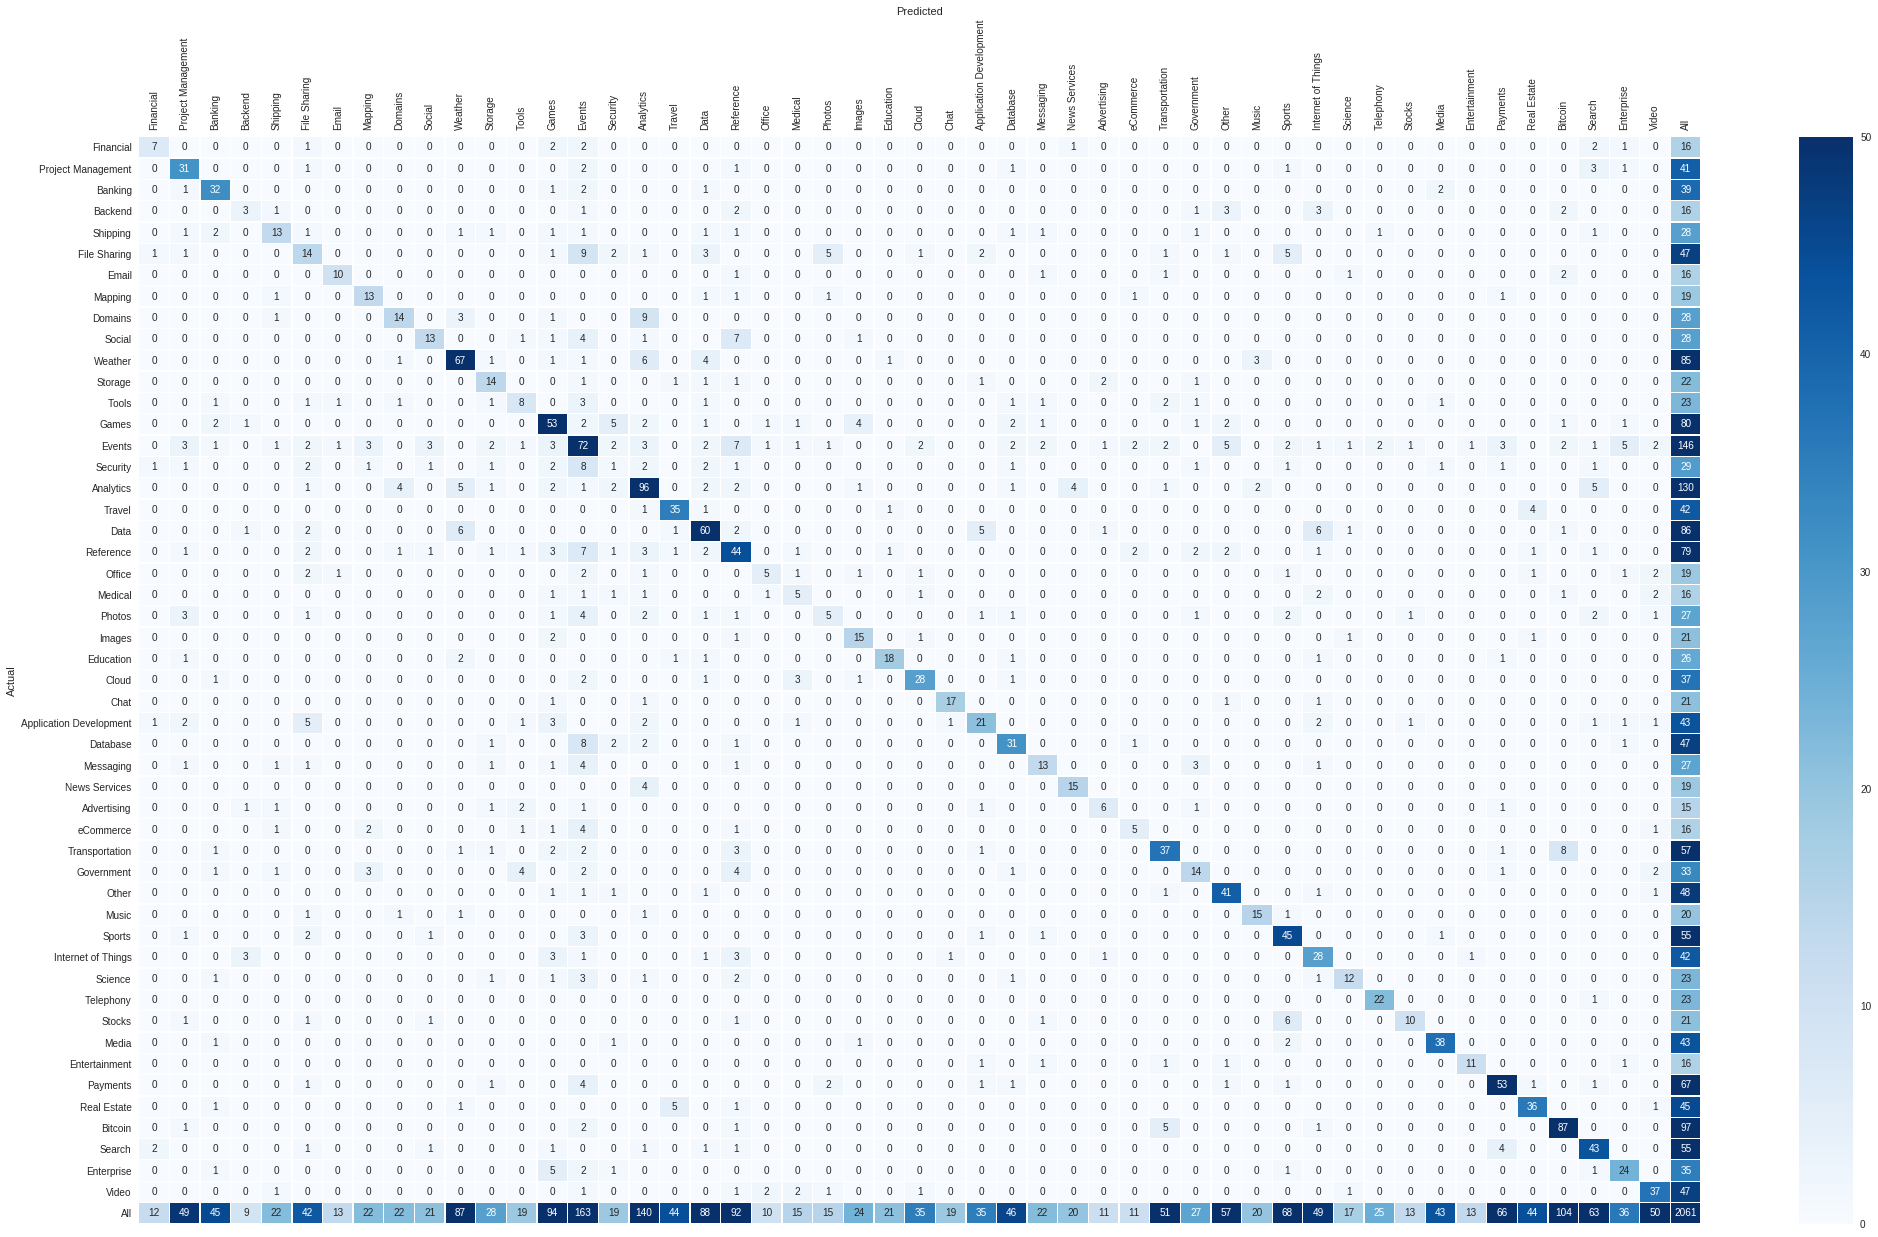

In [0]:
f, ax = plt.subplots(figsize=(35,20))

sns.heatmap(cross, annot=True, vmin=0, fmt="d", vmax=50, ax=ax, linewidths=.3, cmap=plt.cm.Blues)

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')


plt.yticks(rotation=0) 
plt.xticks(rotation=90) 

plt.savefig('ServeNet/heatmap.pdf', format='pdf', dpi=300)